In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
from google.colab.patches import cv2_imshow as sh
from skimage import measure, color, io
import glob

In [83]:
fractographs  = glob.glob('/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/*.*')
fractographs.sort()

In [84]:
fractographs

['/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image20.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image21.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image22.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image23.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image24.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image25.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image26.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image27.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image28.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image29.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image30.png',
 '/content/drive/MyDrive/BTP/Result- Part-2/Dataset/Dataset_Part_2/image31.png',
 '/content/drive/MyDrive/BTP

In [86]:
image_idx = 16
iter = 50
mul_param = 0.22
conc_thresh = 0.4
area_thresh = 6000

In [87]:
name, ext = fractographs[image_idx].split('/')[-1].split('.')

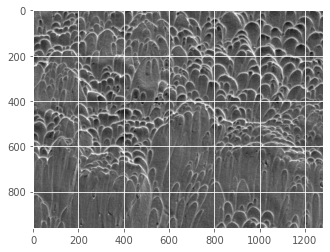

In [88]:
img = cv2.imread(fractographs[image_idx], 0)
plt.imshow(img, cmap='gray')

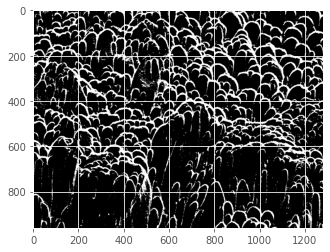

In [89]:
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

In [90]:
kernel = np.ones((1, 1), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=iter)
opening = (np.logical_not(opening)).astype(np.uint8)

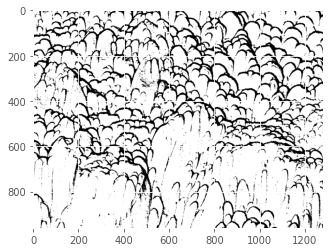

In [91]:
plt.imshow(opening, cmap='gray')

In [92]:
sure_bg = cv2.dilate(opening, kernel, iterations=iter)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
ret2, sure_fg = cv2.threshold(dist_transform, mul_param*dist_transform.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)
unknown = cv2.subtract(sure_bg, sure_fg)

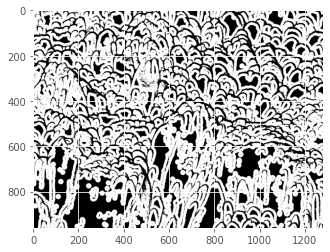

In [93]:
plt.imshow(unknown, cmap='gray')

In [94]:
ret3, markers = cv2.connectedComponents(sure_fg)
markers = markers+10
markers[unknown==1] = 0

In [95]:
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(img, np.int32(markers))
img2 = color.label2rgb(markers, bg_label=10)

<Figure size 432x576 with 0 Axes>

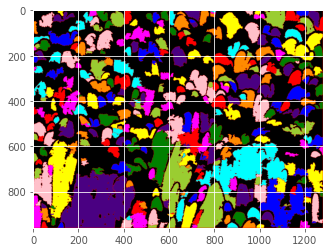

<Figure size 432x576 with 0 Axes>

In [96]:
plt.imshow(img2, cmap='jet')
plt.figure(figsize=(6, 8))

In [97]:
skeleton_img = np.zeros(img.shape, dtype=np.uint8)
skeleton_img[markers == -1] = [255, 255, 255]

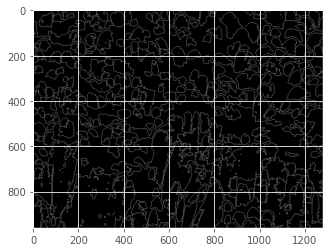

<Figure size 432x576 with 0 Axes>

In [98]:
plt.imshow(skeleton_img)
plt.figure(figsize=(6, 8))
plt.show()

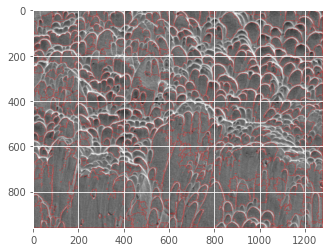

<Figure size 432x576 with 0 Axes>

In [99]:
img[markers == -1] = [255, 0, 0]
plt.imshow(img)
plt.figure(figsize=(6, 8))
plt.show()

In [100]:
# getting centroids of all markers 

center = measure.regionprops(markers, intensity_image=img) 
centroid_arr_x = []
centroid_arr_y = []
for i in range(len(center)):
    centroid_arr_x.append(center[i].centroid[0])
    centroid_arr_y.append(center[i].centroid[1])
centroid_arr_x = np.asarray(centroid_arr_x)
centroid_arr_y = np.asarray(centroid_arr_y)

In [101]:
# taking only the positive markers
x = np.unique(markers)
x = x[x > 0]

In [102]:

props = measure.regionprops_table(markers, intensity_image=img, properties=['area', 'equivalent_diameter', 
                                                                            'mean_intensity', 'orientation', 
                                                                            'perimeter', 'max_intensity' ,
                                                                            'min_intensity', 'major_axis_length',
                                                                            'minor_axis_length'])


props['concavity'] = props['perimeter']/props['area']
props['marker num'] = x
df = pd.DataFrame(props)
df['x center'] = centroid_arr_x
df['y center'] = centroid_arr_y
df.drop(df.index[(df['marker num'] == 10)], axis=0, inplace=True)
df.drop('mean_intensity-1', axis=1, inplace=True)
df.drop('mean_intensity-2', axis=1, inplace=True)
df.drop('max_intensity-1', axis=1, inplace=True)
df.drop('max_intensity-2', axis=1, inplace=True)
df.drop('min_intensity-1', axis=1, inplace=True)
df.drop('min_intensity-2', axis=1, inplace=True)


In [103]:
df

,area,equivalent_diameter,mean_intensity-0,orientation,perimeter,max_intensity-0,min_intensity-0,major_axis_length,minor_axis_length,concavity,marker num,x center,y center
1,401,22.595775,103.950125,0.745248,101.669048,137,76,30.876731,20.781828,0.253539,11,10.044888,122.897756
2,733,30.549707,111.900409,-1.421363,135.083261,136,86,35.015567,28.287329,0.184288,13,13.226467,264.328786
3,1612,45.304107,108.044665,0.767317,222.314755,137,79,61.384367,36.108625,0.137912,14,23.148263,306.325062
4,2018,50.689224,101.351338,1.246962,225.030483,137,74,72.553876,39.942036,0.111512,15,17.343409,707.293855
5,1825,48.204379,103.272329,-0.303779,217.758405,132,76,73.529653,33.613007,0.119320,16,30.177534,753.235616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,478,24.669992,104.882845,0.300166,97.840620,132,89,29.479577,23.202577,0.204687,373,947.468619,48.631799
360,426,23.289484,101.706573,-0.546315,86.148232,127,76,27.322090,22.266138,0.202226,374,948.673709,123.767606
361,464,24.306031,102.887931,-1.524907,90.491378,134,79,35.280786,17.394649,0.195025,375,951.206897,1003.271552
362,255,18.018770,106.113725,-1.468868,76.390873,137,83,25.481723,13.973382,0.299572,376,952.439216,713.192157


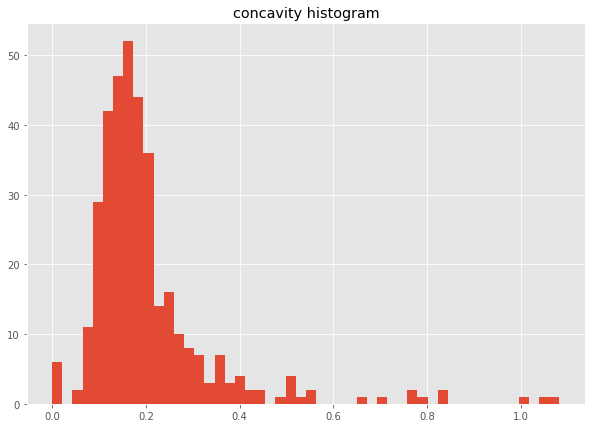

In [104]:
fig = plt.figure(figsize =(10, 7))
 
plt.hist(df['concavity'], bins = 50)
plt.title("concavity histogram")
plt.show()

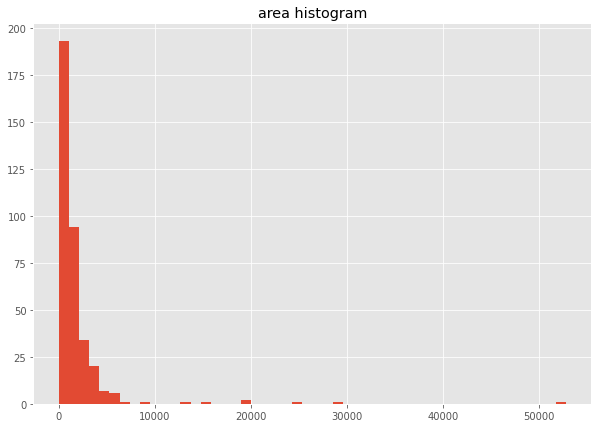

In [105]:
fig = plt.figure(figsize =(10, 7))
 
plt.hist(df['area'], bins = 50)
plt.title("area histogram")
plt.show()

In [106]:
df.drop(df.index[(df['concavity'] > conc_thresh)], axis=0, inplace=True)
df.drop(df.index[(df['area'] > area_thresh)], axis=0, inplace=True)
df.drop(df.index[(df['perimeter'] <= 0)], axis=0, inplace=True)
df.drop(df.index[(df['major_axis_length'] <= 0)], axis=0, inplace=True)
df.drop(df.index[(df['minor_axis_length'] <= 0)], axis=0, inplace=True)

In [107]:
df

,area,equivalent_diameter,mean_intensity-0,orientation,perimeter,max_intensity-0,min_intensity-0,major_axis_length,minor_axis_length,concavity,marker num,x center,y center
1,401,22.595775,103.950125,0.745248,101.669048,137,76,30.876731,20.781828,0.253539,11,10.044888,122.897756
2,733,30.549707,111.900409,-1.421363,135.083261,136,86,35.015567,28.287329,0.184288,13,13.226467,264.328786
3,1612,45.304107,108.044665,0.767317,222.314755,137,79,61.384367,36.108625,0.137912,14,23.148263,306.325062
4,2018,50.689224,101.351338,1.246962,225.030483,137,74,72.553876,39.942036,0.111512,15,17.343409,707.293855
5,1825,48.204379,103.272329,-0.303779,217.758405,132,76,73.529653,33.613007,0.119320,16,30.177534,753.235616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,444,23.776424,111.734234,-1.531735,115.077164,137,92,46.124229,14.455349,0.259183,372,952.414414,527.409910
359,478,24.669992,104.882845,0.300166,97.840620,132,89,29.479577,23.202577,0.204687,373,947.468619,48.631799
360,426,23.289484,101.706573,-0.546315,86.148232,127,76,27.322090,22.266138,0.202226,374,948.673709,123.767606
361,464,24.306031,102.887931,-1.524907,90.491378,134,79,35.280786,17.394649,0.195025,375,951.206897,1003.271552


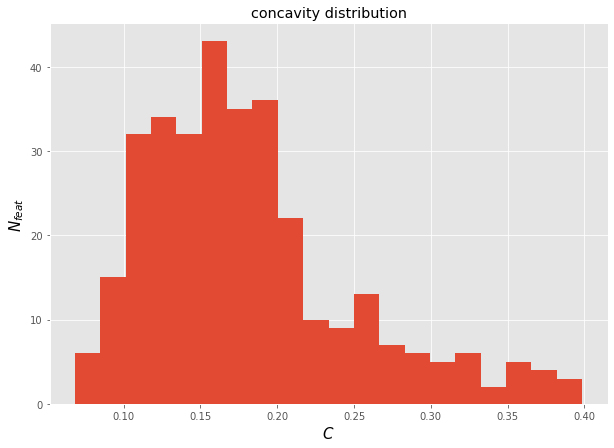

In [108]:
fig = plt.figure(figsize =(10, 7))
plt.style.use('ggplot')
plt.hist(df['concavity'], bins = 20)
plt.title("concavity distribution")
plt.xlabel('$ C $', fontsize=15, color='black')
plt.ylabel('$ N_{feat} $', fontsize=15, color='black')
plt.show()

In [109]:
df['m/d_eq'] = np.asarray(df['major_axis_length']/df['equivalent_diameter'])

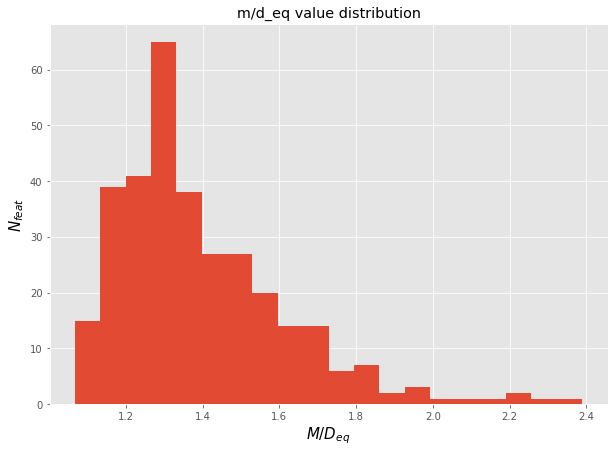

In [110]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot') 
plt.hist(df['m/d_eq'], bins =20)
plt.title("m/d_eq value distribution")
plt.xlabel('$M/D_{eq}$', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()


In [111]:
G1_max_x = np.asarray(df['x center']) + (np.asarray(df['major_axis_length'])/2)*np.cos(np.degrees(np.asarray(df['orientation'])))
G1_max_y = np.asarray(df['y center']) + (np.asarray(df['major_axis_length'])/2)*np.sin(np.degrees(np.asarray(df['orientation'])))

#G1_min_x = np.asarray(df['x center']) - (np.asarray(df['major_axis_length'])/2)*np.cos(np.degrees(np.asarray(df['orientation'])))
#G1_min_y = np.asarray(df['y center']) - (np.asarray(df['major_axis_length'])/2)*np.sin(np.degrees(np.asarray(df['orientation'])))

G1_min_x = np.asarray(df['x center'])
G1_min_y = np.asarray(df['y center'])

In [112]:
G1_max_x = G1_max_x.astype(np.int32)
G1_max_y = G1_max_y.astype(np.int32)
G1_min_x = G1_min_x.astype(np.int32)
G1_min_y = G1_min_y.astype(np.int32)

In [113]:
G1_max_x[G1_max_x >= 960] = 959
G1_max_y[G1_max_y >= 1280] = 1279
G1_min_x[G1_min_x >= 960] = 959
G1_min_y[G1_min_y >= 1280] = 1279

In [114]:
G1 = np.absolute(img[G1_max_x, G1_max_y, 0]-img[G1_min_x, G1_min_y, 0])/np.asarray(df['major_axis_length'])

In [115]:
G2_max_x = np.asarray(df['x center']) + (np.asarray(df['minor_axis_length'])/2)*np.cos(np.degrees(np.asarray(df['orientation'])))
G2_max_y = np.asarray(df['y center']) - (np.asarray(df['minor_axis_length'])/2)*np.sin(np.degrees(np.asarray(df['orientation'])))

#G2_min_x = np.asarray(df['x center']) - (np.asarray(df['minor_axis_length'])/2)*np.cos(np.degrees(np.asarray(df['orientation'])))
#G2_min_y = np.asarray(df['y center']) + (np.asarray(df['minor_axis_length'])/2)*np.sin(np.degrees(np.asarray(df['orientation'])))

G2_min_x = np.asarray(df['x center'])
G2_min_y = np.asarray(df['y center'])

In [116]:
G2_max_x = G2_max_x.astype(np.int32)
G2_max_y = G2_max_y.astype(np.int32)
G2_min_x = G2_min_x.astype(np.int32)
G2_min_y = G2_min_y.astype(np.int32)

In [117]:
G2_max_x[G2_max_x >= 960] = 959
G2_max_y[G2_max_y >= 1280] = 1279
G2_min_x[G2_min_x >= 960] = 959
G2_min_y[G2_min_y >= 1280] = 1279

In [118]:
G2 = np.absolute(img[G2_max_x, G2_max_y, 0]-img[G2_min_x, G2_min_y, 0])/np.asarray(df['minor_axis_length'])

In [119]:
df['gradients ratio'] = G2/G1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [120]:
#df.drop(df.index[~np.isfinite(df['gradients ratio'])], axis=0, inplace=True)

In [121]:
df['gradients ratio'] = np.absolute(np.log10(df['gradients ratio']))

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [122]:
df

,area,equivalent_diameter,mean_intensity-0,orientation,perimeter,max_intensity-0,min_intensity-0,major_axis_length,minor_axis_length,concavity,marker num,x center,y center,m/d_eq,gradients ratio
1,401,22.595775,103.950125,0.745248,101.669048,137,76,30.876731,20.781828,0.253539,11,10.044888,122.897756,1.366482,0.133881
2,733,30.549707,111.900409,-1.421363,135.083261,136,86,35.015567,28.287329,0.184288,13,13.226467,264.328786,1.146183,0.701069
3,1612,45.304107,108.044665,0.767317,222.314755,137,79,61.384367,36.108625,0.137912,14,23.148263,306.325062,1.354940,0.054356
4,2018,50.689224,101.351338,1.246962,225.030483,137,74,72.553876,39.942036,0.111512,15,17.343409,707.293855,1.431347,0.250312
5,1825,48.204379,103.272329,-0.303779,217.758405,132,76,73.529653,33.613007,0.119320,16,30.177534,753.235616,1.525373,1.135140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,444,23.776424,111.734234,-1.531735,115.077164,137,92,46.124229,14.455349,0.259183,372,952.414414,527.409910,1.939914,0.503901
359,478,24.669992,104.882845,0.300166,97.840620,132,89,29.479577,23.202577,0.204687,373,947.468619,48.631799,1.194957,0.572709
360,426,23.289484,101.706573,-0.546315,86.148232,127,76,27.322090,22.266138,0.202226,374,948.673709,123.767606,1.173151,0.088869
361,464,24.306031,102.887931,-1.524907,90.491378,134,79,35.280786,17.394649,0.195025,375,951.206897,1003.271552,1.451524,0.518631


In [123]:
param2 = df['gradients ratio']
param2[~np.isfinite(param2)] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


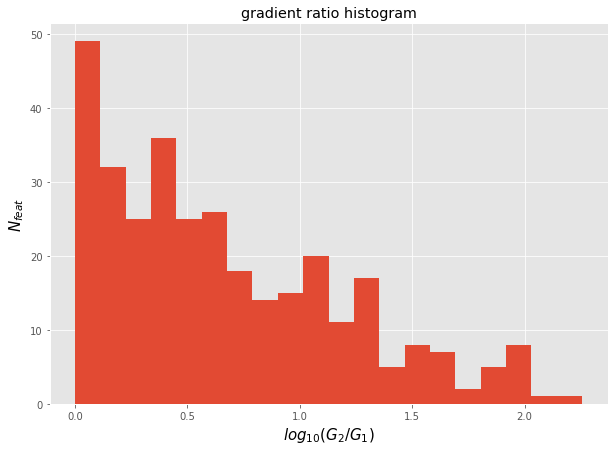

In [124]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(param2, bins=20)
plt.title("gradient ratio histogram")
plt.xlabel('$log_{10}(G_2/G_1)$', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [125]:
regions = np.asarray(df['marker num'])
Kc = []
for region in regions:
    coords = np.where(markers == region)
    c_x = (df.loc[df['marker num'] == region, ['x center']]).to_numpy()[0]
    c_y = (df.loc[df['marker num'] == region, ['y center']]).to_numpy()[0]
    d_eq = (df.loc[df['marker num'] == region, ['equivalent_diameter']]).to_numpy()[0]
    A = (df.loc[df['marker num'] == region, ['area']]).to_numpy()[0]
    r_x = np.asarray(coords[0])-c_x
    r_y = np.asarray(coords[1])-c_y
    D = np.sqrt(r_x**2+r_y**2)
    tot_in = np.sum(2*D < d_eq)
    kc_reg = tot_in/A
    Kc.append(kc_reg)
Kc = np.asarray(Kc)

In [126]:
df['circularity'] = Kc

In [127]:
df

,area,equivalent_diameter,mean_intensity-0,orientation,perimeter,max_intensity-0,min_intensity-0,major_axis_length,minor_axis_length,concavity,marker num,x center,y center,m/d_eq,gradients ratio,circularity
1,401,22.595775,103.950125,0.745248,101.669048,137,76,30.876731,20.781828,0.253539,11,10.044888,122.897756,1.366482,0.133881,0.750623
2,733,30.549707,111.900409,-1.421363,135.083261,136,86,35.015567,28.287329,0.184288,13,13.226467,264.328786,1.146183,0.701069,0.890859
3,1612,45.304107,108.044665,0.767317,222.314755,137,79,61.384367,36.108625,0.137912,14,23.148263,306.325062,1.354940,0.054356,0.810794
4,2018,50.689224,101.351338,1.246962,225.030483,137,74,72.553876,39.942036,0.111512,15,17.343409,707.293855,1.431347,0.250312,0.770565
5,1825,48.204379,103.272329,-0.303779,217.758405,132,76,73.529653,33.613007,0.119320,16,30.177534,753.235616,1.525373,1.135140,0.730411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,444,23.776424,111.734234,-1.531735,115.077164,137,92,46.124229,14.455349,0.259183,372,952.414414,527.409910,1.939914,0.503901,0.549550
359,478,24.669992,104.882845,0.300166,97.840620,132,89,29.479577,23.202577,0.204687,373,947.468619,48.631799,1.194957,0.572709,0.834728
360,426,23.289484,101.706573,-0.546315,86.148232,127,76,27.322090,22.266138,0.202226,374,948.673709,123.767606,1.173151,0.088869,0.842723
361,464,24.306031,102.887931,-1.524907,90.491378,134,79,35.280786,17.394649,0.195025,375,951.206897,1003.271552,1.451524,0.518631,0.754310


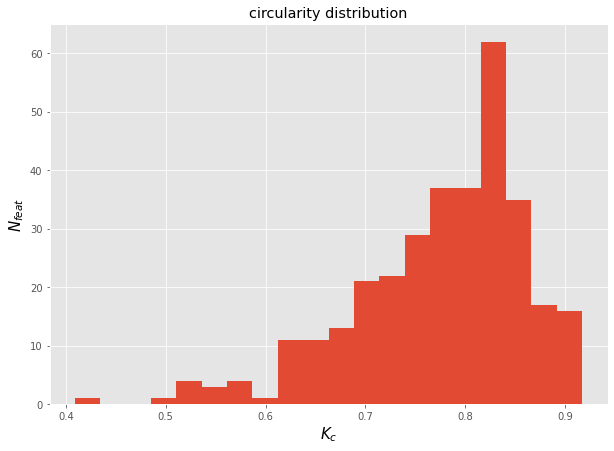

In [128]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(df['circularity'], bins=20)
plt.title("circularity distribution")
plt.xlabel('$K_c$', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [129]:
comb12_1 = df['gradients ratio']*df['m/d_eq']
comb12_1[~np.isfinite(comb12_1)] = 0

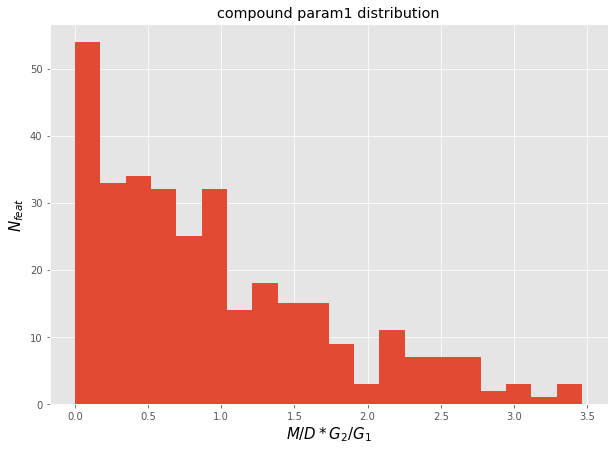

In [130]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(comb12_1, bins=20)
plt.title("compound param1 distribution")
plt.xlabel('$ M/D*G_2/G_1 $', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [131]:
comb12_2 = df['gradients ratio']*(df['m/d_eq']**0.75)
comb12_2[~np.isfinite(comb12_2)] = 0

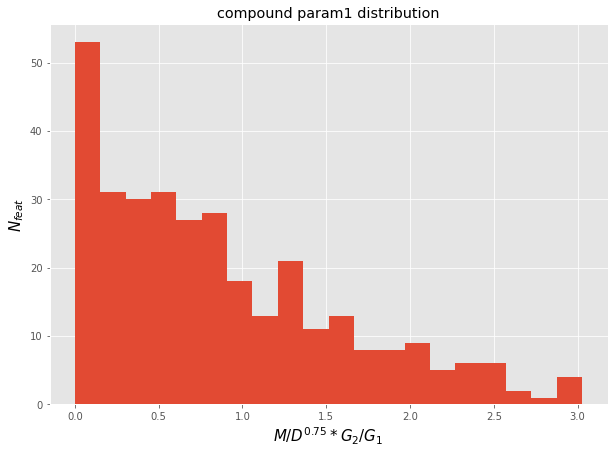

In [132]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(comb12_2, bins=20)
plt.title("compound param1 distribution")
plt.xlabel('$ M/D^{0.75}*G_2/G_1 $', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [133]:
comb23_1 = df['gradients ratio']*(1/df['circularity'])
comb23_1[~np.isfinite(comb23_1)] = 0

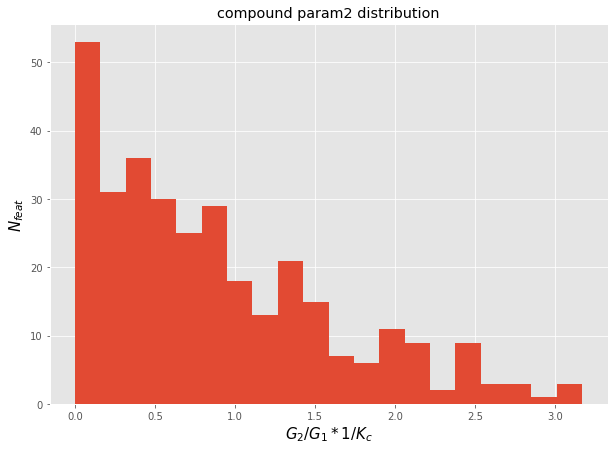

In [134]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(comb23_1, bins=20)
plt.title("compound param2 distribution")
plt.xlabel('$G_2/G_1*1/K_c$', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [135]:
comb23_2 = df['gradients ratio']*((1/df['circularity'])**0.75)
comb23_2[~np.isfinite(comb23_2)] = 0

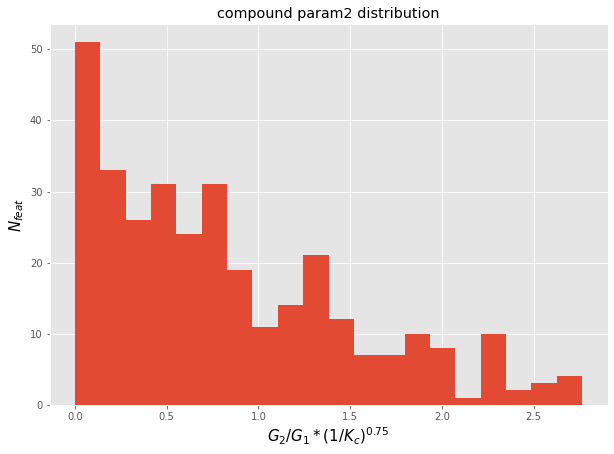

In [136]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(comb23_2, bins=20)
plt.title("compound param2 distribution")
plt.xlabel('$G_2/G_1*(1/K_c)^{0.75}$', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [137]:
comb13_1 = df['m/d_eq']*(1/df['circularity'])
comb13_1[~np.isfinite(comb13_1)] = 0

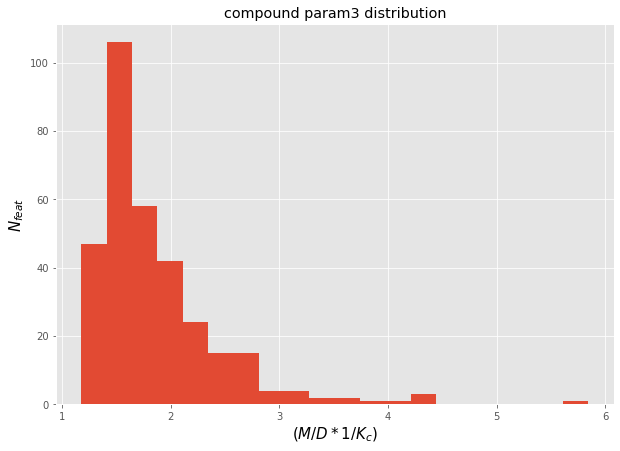

In [138]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(comb13_1, bins=20)
plt.title("compound param3 distribution")
plt.xlabel('$(M/D*1/K_c)$', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [139]:
comb13_2 = (df['m/d_eq'])*((1/df['circularity'])**0.75)
comb13_2[~np.isfinite(comb13_2)] = 0

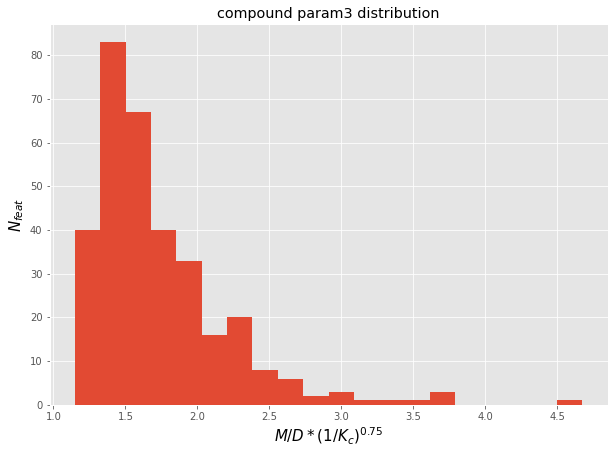

In [140]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(comb13_2, bins=20)
plt.title("compound param3 distribution")
plt.xlabel('$M/D*(1/K_c)^{0.75}$', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [141]:
comb123_1 = df['m/d_eq']*df['gradients ratio']*(1/df['circularity'])
comb123_1[~np.isfinite(comb123_1)] = 0

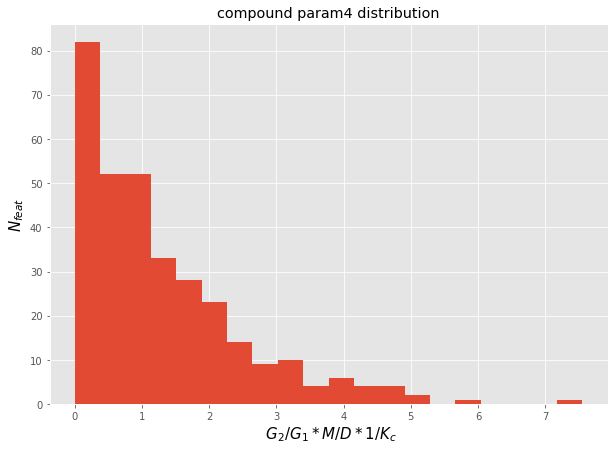

In [142]:
fig = plt.figure(figsize =(10, 7))

plt.style.use('ggplot')
plt.hist(comb123_1, bins=20)
plt.title("compound param4 distribution")
plt.xlabel(r'$\ G_2/G_1*M/D*1/K_c $', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [143]:
comb123_2 = (df['m/d_eq']**0.5)*df['gradients ratio']*((1/df['circularity'])**0.5)
comb123_2[~np.isfinite(comb123_2)] = 0

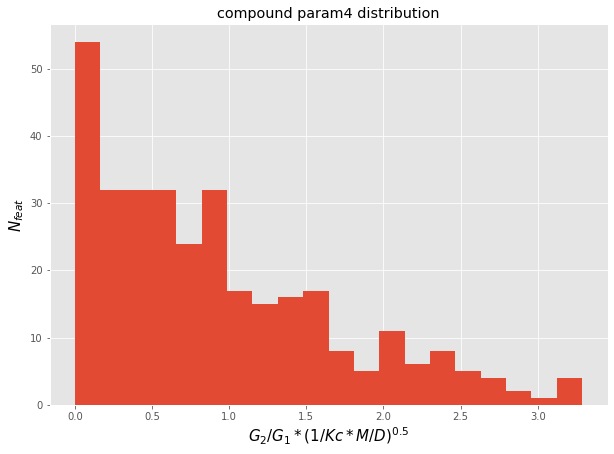

In [144]:
fig = plt.figure(figsize =(10, 7))
formatted = r"$G_2/G_1*(1/Kc*M/D)^{0.5}$"
plt.style.use('ggplot')
plt.hist(comb123_2, bins=20)
plt.title("compound param4 distribution")
plt.xlabel(f'{formatted}', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [145]:
comb123_3 = (df['m/d_eq']**0.5)*df['gradients ratio']*((1/df['circularity'])**0.75)
comb123_3[~np.isfinite(comb123_3)] = 0

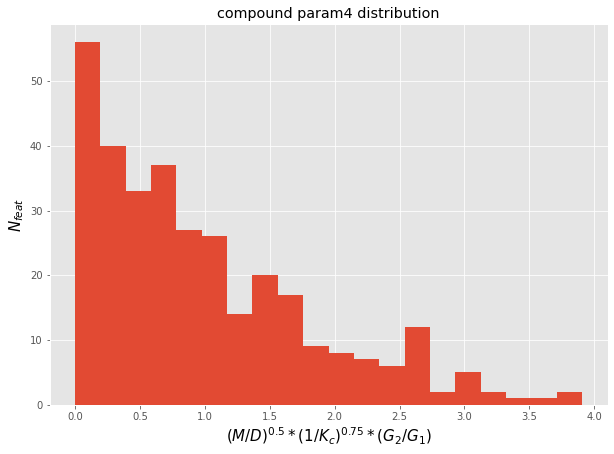

In [146]:
fig = plt.figure(figsize =(10, 7))
formatted = r"$ (M/D)^{0.5}*(1/K_c)^{0.75}*(G_2/G_1) $"
plt.style.use('ggplot')
plt.hist(comb123_3, bins=20)
plt.title("compound param4 distribution")
plt.xlabel(f'{formatted}', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [147]:
comb123_4 = (df['m/d_eq']**0.75)*df['gradients ratio']*((1/df['circularity'])**0.5)
comb123_4[~np.isfinite(comb123_4)] = 0

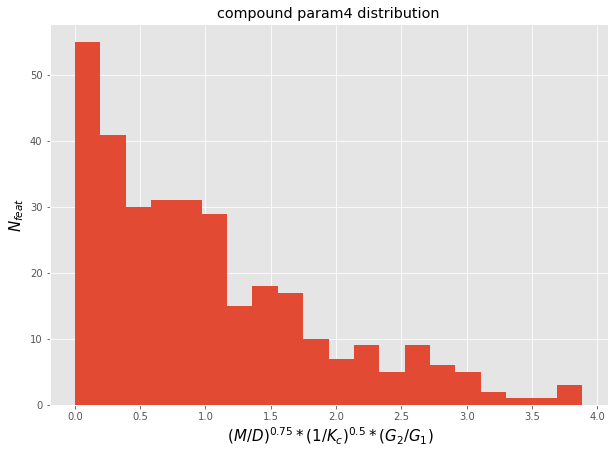

In [148]:
fig = plt.figure(figsize =(10, 7))
formatted = r"$\ (M/D)^{0.75}*(1/K_c)^{0.5}*(G_2/G_1) $"
plt.style.use('ggplot')
plt.hist(comb123_4, bins=20)
plt.title("compound param4 distribution")
plt.xlabel(f'{formatted}', fontsize=15, color='black')
plt.ylabel('$N_{feat}$', fontsize=15, color='black')
plt.show()

In [149]:
df['comb12-1'] = comb12_1
df['comb12-2'] = comb12_2

df['comb23-1'] = comb23_1
df['comb23-2'] = comb23_2

df['comb13-1'] = comb13_1
df['comb13-2'] = comb13_2

df['comb123-1'] = comb123_1
df['comb123-2'] = comb123_2
df['comb123-3'] = comb123_3
df['comb123-4'] = comb123_4


In [150]:
df.columns

Index(['area', 'equivalent_diameter', 'mean_intensity-0', 'orientation',
       'perimeter', 'max_intensity-0', 'min_intensity-0', 'major_axis_length',
       'minor_axis_length', 'concavity', 'marker num', 'x center', 'y center',
       'm/d_eq', 'gradients ratio', 'circularity', 'comb12-1', 'comb12-2',
       'comb23-1', 'comb23-2', 'comb13-1', 'comb13-2', 'comb123-1',
       'comb123-2', 'comb123-3', 'comb123-4'],
      dtype='object')

In [151]:
VGG16_160_activ = np.load('/content/drive/MyDrive/BTP/activations-VGG16-160.npy')
VGG16_320_activ = np.load('/content/drive/MyDrive/BTP/activations-VGG16-320.npy')

VGG19_160_activ = np.load('/content/drive/MyDrive/BTP/activations-VGG19-160.npy')
VGG19_320_activ = np.load('/content/drive/MyDrive/BTP/activations-VGG19-320.npy')

ResNet152_160_activ = np.load('/content/drive/MyDrive/BTP/activations-ResNet152-160.npy')
ResNet152_320_activ = np.load('/content/drive/MyDrive/BTP/activations-ResNet152-320.npy')

InceptionV3_160_activ = np.load('/content/drive/MyDrive/BTP/activations-InceptionV3-160.npy')
InceptionV3_320_activ = np.load('/content/drive/MyDrive/BTP/activations-InceptionV3-320.npy')

DenseNet201_160_activ = np.load('/content/drive/MyDrive/BTP/activations-DenseNet201-160.npy')
DenseNet201_320_activ = np.load('/content/drive/MyDrive/BTP/activations-DenseNet201-320.npy')

In [152]:
# Network - 1
VGG16_160_imgactiv = VGG16_160_activ[image_idx]
VGG16_320_imgactiv = VGG16_320_activ[image_idx]

# Network - 2
VGG19_160_imgactiv = VGG16_160_activ[image_idx]
VGG19_320_imgactiv = VGG16_320_activ[image_idx]

# Network - 3
ResNet152_160_imgactiv = ResNet152_160_activ[image_idx]
ResNet152_320_imgactiv = ResNet152_320_activ[image_idx]

# Network - 4
InceptionV3_160_imgactiv = InceptionV3_160_activ[image_idx]
InceptionV3_320_imgactiv = InceptionV3_320_activ[image_idx]

# Network - 5
DenseNet201_160_imgactiv = DenseNet201_160_activ[image_idx]
DenseNet201_320_imgactiv = DenseNet201_320_activ[image_idx]

In [153]:
VGG16_160_mean = []
VGG16_160_var = []

VGG16_320_mean = []
VGG16_320_var = []

VGG19_160_mean = []
VGG19_160_var = []

VGG19_320_mean = []
VGG19_320_var = []

ResNet152_160_mean = []
ResNet152_160_var = []

ResNet152_320_mean = []
ResNet152_320_var = []

DenseNet201_160_mean = []
DenseNet201_160_var = []

DenseNet201_320_mean = []
DenseNet201_320_var = []

InceptionV3_160_mean = []
InceptionV3_160_var = []

InceptionV3_320_mean = []
InceptionV3_320_var = []

# remove all non positive values from np.unique(markers) then start from index 1.
for marker_num in df['marker num']:
    VGG16_160_mean.append(np.mean(VGG16_160_imgactiv[markers == marker_num]))
    VGG16_160_var.append(np.std(VGG16_160_imgactiv[markers == marker_num])**2)

    VGG16_320_mean.append(np.mean(VGG16_320_imgactiv[markers == marker_num]))
    VGG16_320_var.append(np.std(VGG16_320_imgactiv[markers == marker_num])**2)

    VGG19_160_mean.append(np.mean(VGG19_160_imgactiv[markers == marker_num]))
    VGG19_160_var.append(np.std(VGG19_160_imgactiv[markers == marker_num])**2)

    VGG19_320_mean.append(np.mean(VGG19_320_imgactiv[markers == marker_num]))
    VGG19_320_var.append(np.std(VGG19_320_imgactiv[markers == marker_num])**2)

    ResNet152_160_mean.append(np.mean(ResNet152_160_imgactiv[markers == marker_num]))
    ResNet152_160_var.append(np.std(ResNet152_160_imgactiv[markers == marker_num])**2)

    ResNet152_320_mean.append(np.mean(ResNet152_320_imgactiv[markers == marker_num]))
    ResNet152_320_var.append(np.std(ResNet152_320_imgactiv[markers == marker_num])**2)

    InceptionV3_160_mean.append(np.mean(InceptionV3_160_imgactiv[markers == marker_num]))
    InceptionV3_160_var.append(np.std(InceptionV3_160_imgactiv[markers == marker_num])**2)

    InceptionV3_320_mean.append(np.mean(InceptionV3_320_imgactiv[markers == marker_num]))
    InceptionV3_320_var.append(np.std(InceptionV3_320_imgactiv[markers == marker_num])**2)

    DenseNet201_160_mean.append(np.mean(DenseNet201_160_imgactiv[markers == marker_num]))
    DenseNet201_160_var.append(np.std(DenseNet201_160_imgactiv[markers == marker_num])**2)

    DenseNet201_320_mean.append(np.mean(DenseNet201_320_imgactiv[markers == marker_num]))
    DenseNet201_320_var.append(np.std(DenseNet201_320_imgactiv[markers == marker_num])**2)


df['VGG16_160_mean'] = np.asarray(VGG16_160_mean)
df['VGG16_160_var'] = np.asarray(VGG16_160_var)

df['VGG16_320_mean'] = np.asarray(VGG16_320_mean)
df['VGG16_320_var'] = np.asarray(VGG16_320_var)

df['VGG19_160_mean'] = np.asarray(VGG19_160_mean)
df['VGG19_160_var'] = np.asarray(VGG19_160_var)

df['VGG19_320_mean'] = np.asarray(VGG19_320_mean)
df['VGG19_320_var'] = np.asarray(VGG19_320_var)

df['ResNet152_160_mean'] = np.asarray(ResNet152_160_mean)
df['ResNet152_160_var'] = np.asarray(ResNet152_160_var)

df['ResNet152_320_mean'] = np.asarray(ResNet152_320_mean)
df['ResNet152_320_var'] = np.asarray(ResNet152_320_var)

df['InceptionV3_160_mean'] = np.asarray(InceptionV3_160_mean)
df['InceptionV3_160_var'] = np.asarray(InceptionV3_160_var)

df['InceptionV3_320_mean'] = np.asarray(InceptionV3_320_mean)
df['InceptionV3_320_var'] = np.asarray(InceptionV3_320_var)

df['DenseNet201_160_mean'] = np.asarray(DenseNet201_160_mean)
df['DenseNet201_160_var'] = np.asarray(DenseNet201_160_var)

df['DenseNet201_320_mean'] = np.asarray(DenseNet201_320_mean)
df['DenseNet201_320_var'] = np.asarray(DenseNet201_320_var)


In [154]:
df

,area,equivalent_diameter,mean_intensity-0,orientation,perimeter,max_intensity-0,min_intensity-0,major_axis_length,minor_axis_length,concavity,...,ResNet152_320_mean,ResNet152_320_var,InceptionV3_160_mean,InceptionV3_160_var,InceptionV3_320_mean,InceptionV3_320_var,DenseNet201_160_mean,DenseNet201_160_var,DenseNet201_320_mean,DenseNet201_320_var
1,401,22.595775,103.950125,0.745248,101.669048,137,76,30.876731,20.781828,0.253539,...,10.152843,0.074138,7.055114,0.261474,1.541911,0.007639,2.531213,0.008946,2.387853,0.008282
2,733,30.549707,111.900409,-1.421363,135.083261,136,86,35.015567,28.287329,0.184288,...,3.751277,0.725583,21.073163,1.747753,13.709322,1.470320,2.235950,0.013516,2.406830,0.026429
3,1612,45.304107,108.044665,0.767317,222.314755,137,79,61.384367,36.108625,0.137912,...,3.360018,1.761985,24.234059,8.682905,10.527921,14.891480,2.518342,1.086857,2.509926,0.553699
4,2018,50.689224,101.351338,1.246962,225.030483,137,74,72.553876,39.942036,0.111512,...,8.564398,1.812086,27.995606,2.287242,5.287070,0.162928,7.040020,0.508447,6.805298,0.337502
5,1825,48.204379,103.272329,-0.303779,217.758405,132,76,73.529653,33.613007,0.119320,...,14.690364,3.436131,26.806835,2.051123,5.974914,1.106844,8.419570,0.679585,7.890765,0.417372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,444,23.776424,111.734234,-1.531735,115.077164,137,92,46.124229,14.455349,0.259183,...,7.640196,0.411563,18.778334,1.768529,4.220769,0.453589,3.314190,0.065880,2.761708,0.006577
359,478,24.669992,104.882845,0.300166,97.840620,132,89,29.479577,23.202577,0.204687,...,9.487327,2.308188,29.336518,2.714134,3.803269,0.016018,3.683399,0.102082,3.830283,0.110136
360,426,23.289484,101.706573,-0.546315,86.148232,127,76,27.322090,22.266138,0.202226,...,14.158533,1.790816,30.950801,2.072000,3.380759,0.110947,3.381922,0.097582,4.096789,0.078531
361,464,24.306031,102.887931,-1.524907,90.491378,134,79,35.280786,17.394649,0.195025,...,4.947261,0.633469,36.396479,2.866050,7.130088,0.265071,2.885277,0.049477,2.741627,0.041112


In [155]:
df.drop(df.index[~np.isfinite(df['gradients ratio'])], axis=0, inplace=True)

In [156]:
df

,area,equivalent_diameter,mean_intensity-0,orientation,perimeter,max_intensity-0,min_intensity-0,major_axis_length,minor_axis_length,concavity,...,ResNet152_320_mean,ResNet152_320_var,InceptionV3_160_mean,InceptionV3_160_var,InceptionV3_320_mean,InceptionV3_320_var,DenseNet201_160_mean,DenseNet201_160_var,DenseNet201_320_mean,DenseNet201_320_var
1,401,22.595775,103.950125,0.745248,101.669048,137,76,30.876731,20.781828,0.253539,...,10.152843,0.074138,7.055114,0.261474,1.541911,0.007639,2.531213,0.008946,2.387853,0.008282
2,733,30.549707,111.900409,-1.421363,135.083261,136,86,35.015567,28.287329,0.184288,...,3.751277,0.725583,21.073163,1.747753,13.709322,1.470320,2.235950,0.013516,2.406830,0.026429
3,1612,45.304107,108.044665,0.767317,222.314755,137,79,61.384367,36.108625,0.137912,...,3.360018,1.761985,24.234059,8.682905,10.527921,14.891480,2.518342,1.086857,2.509926,0.553699
4,2018,50.689224,101.351338,1.246962,225.030483,137,74,72.553876,39.942036,0.111512,...,8.564398,1.812086,27.995606,2.287242,5.287070,0.162928,7.040020,0.508447,6.805298,0.337502
5,1825,48.204379,103.272329,-0.303779,217.758405,132,76,73.529653,33.613007,0.119320,...,14.690364,3.436131,26.806835,2.051123,5.974914,1.106844,8.419570,0.679585,7.890765,0.417372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,444,23.776424,111.734234,-1.531735,115.077164,137,92,46.124229,14.455349,0.259183,...,7.640196,0.411563,18.778334,1.768529,4.220769,0.453589,3.314190,0.065880,2.761708,0.006577
359,478,24.669992,104.882845,0.300166,97.840620,132,89,29.479577,23.202577,0.204687,...,9.487327,2.308188,29.336518,2.714134,3.803269,0.016018,3.683399,0.102082,3.830283,0.110136
360,426,23.289484,101.706573,-0.546315,86.148232,127,76,27.322090,22.266138,0.202226,...,14.158533,1.790816,30.950801,2.072000,3.380759,0.110947,3.381922,0.097582,4.096789,0.078531
361,464,24.306031,102.887931,-1.524907,90.491378,134,79,35.280786,17.394649,0.195025,...,4.947261,0.633469,36.396479,2.866050,7.130088,0.265071,2.885277,0.049477,2.741627,0.041112


In [157]:
df.columns

Index(['area', 'equivalent_diameter', 'mean_intensity-0', 'orientation',
       'perimeter', 'max_intensity-0', 'min_intensity-0', 'major_axis_length',
       'minor_axis_length', 'concavity', 'marker num', 'x center', 'y center',
       'm/d_eq', 'gradients ratio', 'circularity', 'comb12-1', 'comb12-2',
       'comb23-1', 'comb23-2', 'comb13-1', 'comb13-2', 'comb123-1',
       'comb123-2', 'comb123-3', 'comb123-4', 'VGG16_160_mean',
       'VGG16_160_var', 'VGG16_320_mean', 'VGG16_320_var', 'VGG19_160_mean',
       'VGG19_160_var', 'VGG19_320_mean', 'VGG19_320_var',
       'ResNet152_160_mean', 'ResNet152_160_var', 'ResNet152_320_mean',
       'ResNet152_320_var', 'InceptionV3_160_mean', 'InceptionV3_160_var',
       'InceptionV3_320_mean', 'InceptionV3_320_var', 'DenseNet201_160_mean',
       'DenseNet201_160_var', 'DenseNet201_320_mean', 'DenseNet201_320_var'],
      dtype='object')

In [158]:
df.drop('x center', axis=1, inplace=True)
df.drop('y center', axis=1, inplace=True)
#df.drop('marker num', axis=1, inplace=True)

In [159]:
df

,area,equivalent_diameter,mean_intensity-0,orientation,perimeter,max_intensity-0,min_intensity-0,major_axis_length,minor_axis_length,concavity,...,ResNet152_320_mean,ResNet152_320_var,InceptionV3_160_mean,InceptionV3_160_var,InceptionV3_320_mean,InceptionV3_320_var,DenseNet201_160_mean,DenseNet201_160_var,DenseNet201_320_mean,DenseNet201_320_var
1,401,22.595775,103.950125,0.745248,101.669048,137,76,30.876731,20.781828,0.253539,...,10.152843,0.074138,7.055114,0.261474,1.541911,0.007639,2.531213,0.008946,2.387853,0.008282
2,733,30.549707,111.900409,-1.421363,135.083261,136,86,35.015567,28.287329,0.184288,...,3.751277,0.725583,21.073163,1.747753,13.709322,1.470320,2.235950,0.013516,2.406830,0.026429
3,1612,45.304107,108.044665,0.767317,222.314755,137,79,61.384367,36.108625,0.137912,...,3.360018,1.761985,24.234059,8.682905,10.527921,14.891480,2.518342,1.086857,2.509926,0.553699
4,2018,50.689224,101.351338,1.246962,225.030483,137,74,72.553876,39.942036,0.111512,...,8.564398,1.812086,27.995606,2.287242,5.287070,0.162928,7.040020,0.508447,6.805298,0.337502
5,1825,48.204379,103.272329,-0.303779,217.758405,132,76,73.529653,33.613007,0.119320,...,14.690364,3.436131,26.806835,2.051123,5.974914,1.106844,8.419570,0.679585,7.890765,0.417372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,444,23.776424,111.734234,-1.531735,115.077164,137,92,46.124229,14.455349,0.259183,...,7.640196,0.411563,18.778334,1.768529,4.220769,0.453589,3.314190,0.065880,2.761708,0.006577
359,478,24.669992,104.882845,0.300166,97.840620,132,89,29.479577,23.202577,0.204687,...,9.487327,2.308188,29.336518,2.714134,3.803269,0.016018,3.683399,0.102082,3.830283,0.110136
360,426,23.289484,101.706573,-0.546315,86.148232,127,76,27.322090,22.266138,0.202226,...,14.158533,1.790816,30.950801,2.072000,3.380759,0.110947,3.381922,0.097582,4.096789,0.078531
361,464,24.306031,102.887931,-1.524907,90.491378,134,79,35.280786,17.394649,0.195025,...,4.947261,0.633469,36.396479,2.866050,7.130088,0.265071,2.885277,0.049477,2.741627,0.041112


In [160]:
name, ext = fractographs[image_idx].split('/')[-1].split('.')

In [161]:
name

'image36'

In [162]:
df.to_excel(f'/content/drive/MyDrive/BTP/Result- Part-2/Statistics with feature_eng2/{name}.xls', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.
